In [1]:
# Import packages
import os
import sys
# FIXME: avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
# sys.path.append(os.path.join(os.path.dirname(__file__), '../../'))
import numpy as np
from scipy.special import hankel1
from scipy.sparse.linalg import LinearOperator, gmres
from analytical import penetrable_circle
from scipy.linalg import toeplitz
import time
from vines.geometry.geometry import shape_2d
from vines.operators.acoustic_operators import get_operator_2d

In [8]:
ko = 10  # wavenumber (this is arbitrary since we define the shape size in terms of wavelengths)
lam = 2 * np.pi / ko  # wavelength
domain_width = 4 * np.pi
square_side = domain_width  # make side length of square equal to the domain width, can make it smaller if we wish

refInd = 1.1  # refractive index
n_per_lam = 10  # Pixels per wavelength

h_temp = lam / (n_per_lam*refInd)  # temp pixel dimension

wx = domain_width
wy = domain_width

from solver2d import geometry2d

x, Area, a, M, N, dx, dy = geometry2d(h_temp, wx, wy)

In [9]:
perm = np.ones(M*N)  # permittivities
# Hexagonal scatterer
rad = domain_width/2
theta = np.linspace(0, 2*np.pi, 7)

In [10]:
# Generate vertices and locate points inside the polygon
xv = rad * np.cos(theta)
yv = rad * np.sin(theta)

verts = np.ones((len(theta), 2))
for i in range(len(theta)):
    verts[i] = np.array([xv[i], yv[i]])

In [11]:
from matplotlib import path
p = path.Path(verts)
xy = [(np.real(x[i,0]), np.imag(x[i,0])) for i in range(x.shape[0])]

In [12]:
IDX = p.contains_points(xy)
idx = np.where(IDX)

In [13]:
perm[idx[0]] = refInd**2
Mr = perm - 1

MR = Mr.reshape(M, N, order='F')

In [14]:
# Get Toeplitz operator
from solver2d import get_operator
toep = get_operator(Area, ko, x, a, M, N)

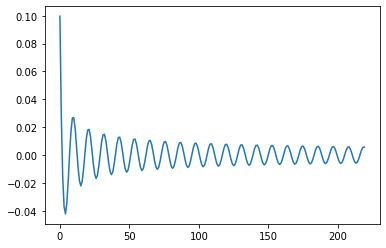

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.real(toep[0,:]))

In [29]:
# Perform circulant embedding of Toeplitz matrix
from solver2d import circulant_embedding
opCirc = circulant_embedding(toep, M ,N)

In [30]:
Area

0.003262679140855986

In [31]:
toep

array([[ 0.09964   +0.08156698j,  0.02818757+0.07504825j,
        -0.0155836 +0.0570479j , ...,  0.00349842-0.00468318j,
         0.00546241-0.00204362j,  0.0056871 +0.0012312j ],
       [ 0.02818757+0.07504825j,  0.00646093+0.06879358j,
        -0.02233845+0.05154302j, ...,  0.00350456-0.00467854j,
         0.00546505-0.00203645j,  0.00568546+0.00123861j],
       [-0.0155836 +0.0570479j , -0.02233845+0.05154302j,
        -0.03472874+0.03641994j, ...,  0.00352295-0.00466459j,
         0.00547293-0.00201493j,  0.00568048+0.00126083j],
       ...,
       [ 0.00349842-0.00468318j,  0.00350456-0.00467854j,
         0.00352295-0.00466459j, ...,  0.00486224+0.00072205j,
         0.00418121+0.00257382j,  0.00282442+0.00400927j],
       [ 0.00546241-0.00204362j,  0.00546505-0.00203645j,
         0.00547293-0.00201493j, ...,  0.00418121+0.00257382j,
         0.00283185+0.00400405j,  0.00102697+0.00478979j],
       [ 0.0056871 +0.0012312j ,  0.00568546+0.00123861j,
         0.00568048+0.00126083

In [32]:
# Define matrix-vector product and corresponding linear operator
def mvp(xIn):
    xInRO = xIn.reshape(M, N, order='F')
    XFFT = np.fft.fftn(xInRO, [2 * M, 2 * N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = MR * xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M * N, 1), dtype=np.complex128)
    xOut[idx[0]] = (xOutArray.reshape(M * N, 1, order='F'))[idx[0]]
    return xOut


A = LinearOperator((M*N, M*N), matvec=mvp)

it_count = 0


def iteration_counter(x):
    global it_count
    it_count += 1

In [33]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
from solver2d import circulant_preconditioner
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

# Define matrix-vector product with circulant preconditoner
def mvp_circ(x, circ_inv, M, N, IDX):
    x_r = x
    # from IPython import embed; embed()
    x_r[np.invert(IDX)] = 0.0 
    x_rhs = x_r.reshape(M*N, 1, order='F')

    temp = x_rhs.reshape(M, N, order='F')
    temp = np.fft.fft(temp, axis=0).T
    for i in range(0, M):
        temp[:, i] = np.matmul(circ_inv[i, :, :], temp[:, i])

    temp = np.fft.ifft(temp.T, axis=0)
    TEMP = temp.reshape(M*N, 1, order='F')
    TEMP_RO = TEMP
    TEMP_RO[np.invert(IDX)] = 0.0 + 0.0j
    matvec = TEMP_RO.reshape(M*N, 1, order='F')
    return matvec

idx_all = np.ones((M*N, 1), dtype=bool)
# mvp_prec = lambda x: mvp_circ(x, circ_inv, M, N, IDX[:, 0])
mvp_prec = lambda x: mvp_circ(x, circ_inv, M, N, IDX)

prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

Preconditioner assembly time =  1.073552131652832


In [34]:
# Perform solve
angle = 0
eInc = np.zeros((M * N, 1), dtype=np.complex128)
dInc = np.array([np.cos(angle), np.sin(angle)])
eInc[idx[0]] = np.exp(1j * ko * (np.real(x[idx[0]]) * dInc[0] +
                      np.imag(x[idx[0]] * dInc[1])))

In [35]:
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

solp, info = gmres(A, eInc, M=prec, tol=1e-6, callback=iteration_counter)
print("The linear system was solved in {0} iterations".format(it_count))

print('Relative residual = ',
      np.linalg.norm(mvp(solp)-eInc)/np.linalg.norm(eInc))

The linear system was solved in 48 iterations
Relative residual =  6.085588210157335e-07


In [16]:
# Post-processing for evaluating the total field in the domain
def mvp_domain(xIn, opCirc, M, N, MR):
    xInRO = xIn.reshape(M, N, order='F')
    XFFT = np.fft.fftn(MR * xInRO, [2*M, 2*N])
    Y = np.fft.ifftn(opCirc * XFFT)
    xTemp = Y[0:M, 0:N]
    xPerm = xTemp
    xOutArray = xInRO - xPerm
    xOut = np.zeros((M * N, 1), dtype=np.complex128)
    xOut = (xOutArray.reshape(M*N, 1, order='F'))
    return xOut

In [17]:
mvp_eval = mvp_domain(solp, opCirc, M, N, MR)

EINC = np.zeros((M * N, 1), dtype=np.complex128)
EINC = np.exp(1j * ko * (np.real(x)*dInc[0] + np.imag(x*dInc[1])))

E_tot = EINC.reshape(M, N, order='F') \
    - mvp_eval.reshape(M, N, order='F') \
    + solp.reshape(M, N, order='F')

E = mvp_eval.reshape(M, N, order='F')

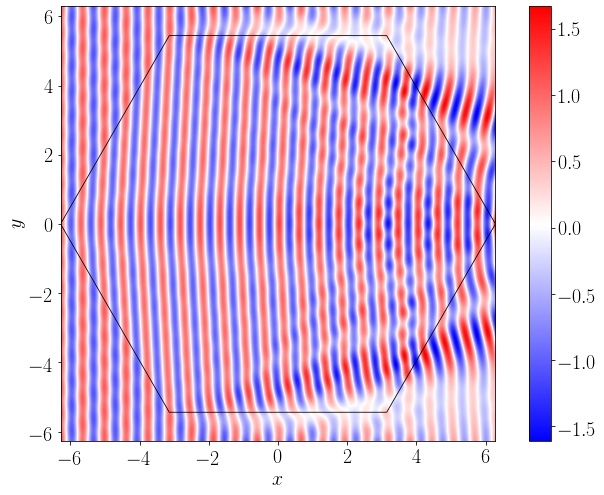

In [19]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
plt.imshow(np.real(E_tot.T), extent=[-wx/2,wx/2,-wy/2,wy/2],
           cmap=plt.cm.get_cmap('bwr'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
# fig.savefig('results/square.png')
# plt.close()